In [16]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
import pandas as pd

In [ ]:
# Load the dataset
file_path = "../data/5M/INTC_5M.csv"
df = pd.read_csv(file_path)

df["timestamp"] = pd.to_datetime(df["Datetime"], utc=True, errors='coerce')
df = df.drop(columns=["Datetime"])

# Drop rows where timestamp conversion resulted in NaT (Not a Time)
df.dropna(subset=["timestamp"], inplace=True)

# Convert timezone-aware datetime to timezone-naive datetime64[ns]
# AutoGluon requires timezone-naive timestamps
df["timestamp"] = df["timestamp"].dt.tz_localize(None)

# Ensure the timestamp column has the correct dtype
print("Timestamp dtype:", df["timestamp"].dtype)
print("Sample timestamps:", df["timestamp"].head())

# Ensure data is sorted by timestamp
df = df.sort_values("timestamp").drop_duplicates()

# Add a static item_id since we're only forecasting for one stock
df["item_id"] = "INTC"

# Select relevant columns and create the TimeSeriesDataFrame
# Use "Close" with a capital C as per the CSV file
df = df[["item_id", "timestamp", "Close"]]

# Create TimeSeriesDataFrame
data = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="item_id",
    timestamp_column="timestamp",
)

data = data.convert_frequency(freq="5T")

data.head(); data.tail() ; data.info()

Timestamp dtype: datetime64[ns]
Sample timestamps: 0   2025-01-23 09:00:00
1   2025-01-23 09:05:00
2   2025-01-23 09:10:00
3   2025-01-23 09:15:00
4   2025-01-23 09:20:00
Name: timestamp, dtype: datetime64[ns]
<class 'autogluon.timeseries.dataset.ts_dataframe.TimeSeriesDataFrame'>
MultiIndex: 24372 entries, ('INTC', Timestamp('2025-01-23 09:00:00')) to ('INTC', Timestamp('2025-04-17 23:55:00'))
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   11089 non-null  float64
dtypes: float64(1)
memory usage: 452.3+ KB


In [ ]:
prediction_length = 40
train_data, test_data = data.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length, target="Close").fit(
    train_data, presets="bolt_small",
)

Beginning AutoGluon training...
AutoGluon will save models to 'c:\Users\micha\code\finance\diploma\notebooks\AutogluonModels\ag-20250702_080648'
AutoGluon will save models to 'c:\Users\micha\code\finance\diploma\notebooks\AutogluonModels\ag-20250702_080648'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          32
GPU Count:          0
Memory Avail:       37.10 GB / 63.10 GB (58.8%)
Disk Space Avail:   124.74 GB / 465.02 GB (26.8%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 40,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection'

Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]


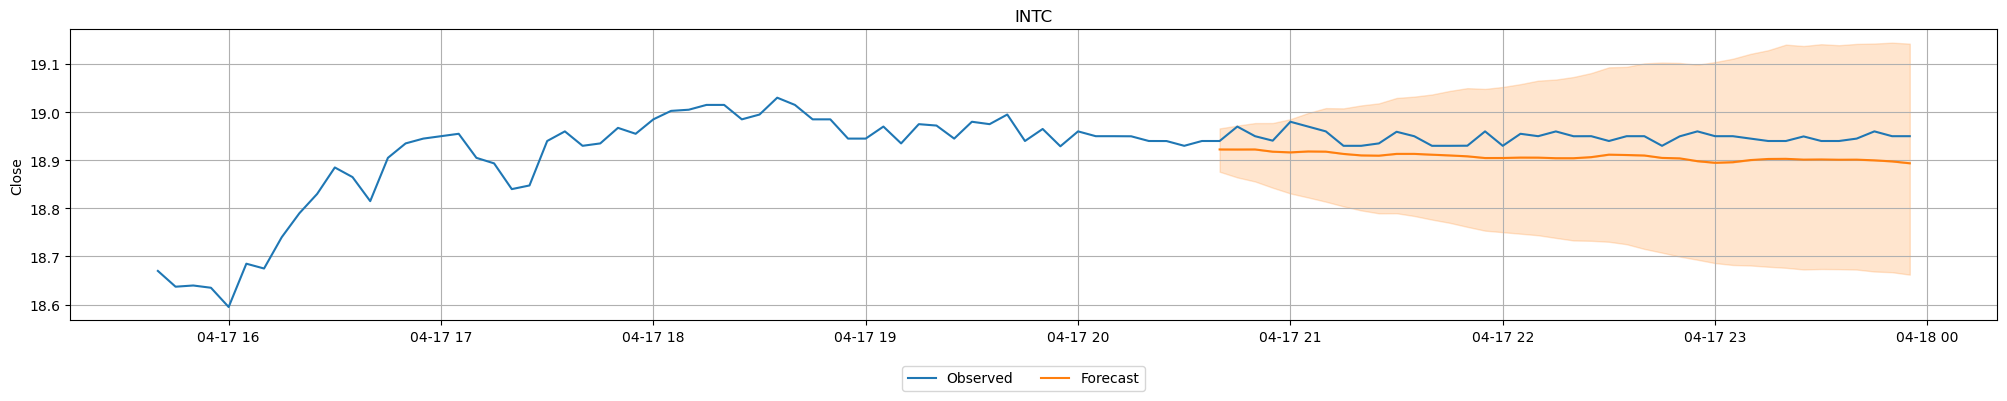

In [35]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=data,
    predictions=predictions,
    item_ids=data.item_ids,
    max_history_length=100,
)